<h1 aling = "center">Pre-processing and Analysis of datasets from Open Data Zurich </h1>

<p>
One of the goals of our project is to study urban environment of Zurich city and afterwards associate it with insurance data. For this purpose, we will be utilizing public datasets published on <a href="url">https://data.stadt-zuerich.ch/</a> website. Datasets we will be using contain, but are not limited to, public parks, schools, street lights, public WCs and etc. in Zurich. This notebook explores and pre-process the above mentioned datasets for later regression with insurance data.
</p>

In [172]:
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt

In [173]:
DATA_FOLDER = "./data/"
SHAPE_FILE_FOLDER = DATA_FOLDER + "shapeFiles/"

## zips.shp file

<p>All files retrieved from the above mentioned website have shape format. Most of them contain spatial information in form of point coordinates (longitude and latitude). In order to identify to which postal code they belong, we will be using zips.shp file that contains polygons describing area of zip codes in Switzerland. Furthermore, we will utilize geopandas functionality to join points with zip codes. One should also pay special attention to coordinate sysem. In order to join correctly all shape files should agree on coordinate system. Therefore, we will take coordinate systems used in zips.shp file as default and convert any other one into it for consistency.
</p>

In [110]:
#read zips data
zips = geopandas.read_file(SHAPE_FILE_FOLDER + "zips.shp")
zips.columns = ['UUID', 'OS_UUID', 'STATUS', 'INAEND', 'ZIP', 'ZUSZIFF','geometry']
print("Postal Codes with %d entries" % zips.shape[0])
display(zips.head(2))

#default coordinate system
COORDINATE_SYSTEM = zips.crs
print("used coordinate system: ", zips.crs)

Postal Codes with 4138 entries


,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF,geometry
0,{0072F991-E46D-447E-A3BE-75467DB57FFC},{281807DC-9C0B-4364-9A55-0E8956876194},real,nein,3920,0,"POLYGON ((7.57585286287061 45.98819190048113, ..."
1,{C3D3316F-1DFE-468E-BFC5-5C2308743B4C},{F065D58C-3F88-46EF-9AA0-DA0A96766333},real,nein,3864,0,"POLYGON ((8.114458487426123 46.54656440076042,..."


used coordinate system:  {'init': 'epsg:4326'}


Since each row describes certain area of postal code in Switzerland. Plotting them should provide us with the map of Switzerland.

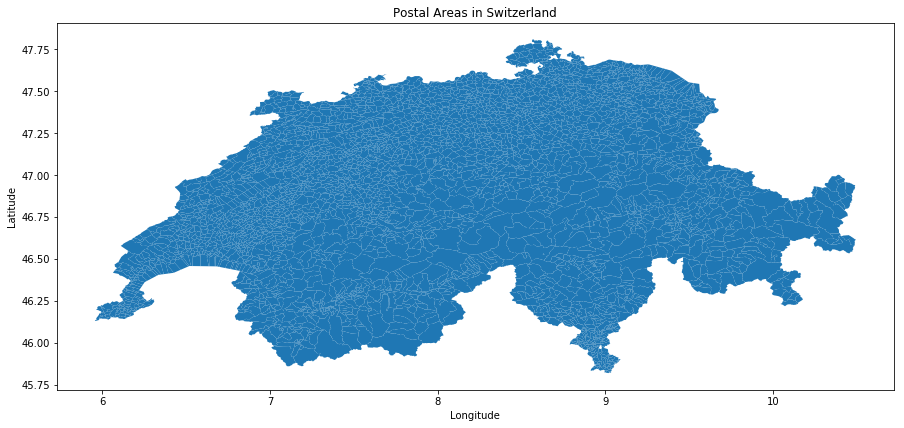

In [111]:
def plot_geopandas(gp):   
    gp.plot(figsize=(15,15))
    plt.title("Postal Areas in Switzerland")
    #longitude latitude (didi latitude aris)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
    
plot_geopandas(zips)

### Methods for shp file aggregation

In [ ]:
def explore_shape_file(file_name):
    df = geopandas.read_file(SHAPE_FILE_FOLDER + file_name)
    print("Number of entries in %s file: %d" % (file_name, df.shape[0]))
    print(df.dtypes)
    display(df.head(2))
    
    #drop duplicates
    G = df["geometry"].apply(lambda geom: geom.wkb)
    df = df.loc[G.drop_duplicates().index]
    
    #coordinate system
    print("coordinate system: ", df.crs)
    if (df.crs != COORDINATE_SYSTEM):
        print("converting to default coordinate system")
        df = df.to_crs(COORDINATE_SYSTEM)
        print("coordinate system: ", df.crs)
    
    display(df.head())
    return df

In [165]:
def grouping_by_zipcode(df, descr):
    #display(df.head())
    #display(df.groupby("ZIP").size().reset_index(name='counts').head())
    df = df.groupby("ZIP").size().reset_index(name='counts')
    df.name = "parks"
    return df

gp = grouping_by_zipcode(df_parks, "parks")
gp.head()

,ZIP,counts
0,8001,14
1,8002,9
2,8003,5
3,8004,6
4,8005,4


### Explore parks in Zurich

Number of entries in park.shp file: 118
infrastruk    object
name          object
www           object
geometry      object
dtype: object


,infrastruk,name,www,geometry
0,Behinderten-WC;NULL,Hardaupark,None,POINT (2680860.90399899 1248189.85139355)
1,NULL;NULL,Gustav-Ammann-Park,http://www.stadt-zuerich.ch/ted/de/index/gsz/n...,POINT (2682686.92528435 1251734.8504504)


coordinate system:  {'init': 'epsg:2056'}
converting to default coordinate system
coordinate system:  {'init': 'epsg:4326'}


,infrastruk,name,www,geometry
0,Behinderten-WC;NULL,Hardaupark,None,POINT (8.50940278693184 47.3795806101971)
1,NULL;NULL,Gustav-Ammann-Park,http://www.stadt-zuerich.ch/ted/de/index/gsz/n...,POINT (8.534235628571883 47.41123530013046)
2,Café_Spielplatz;NULL,GZ Leimbach,None,POINT (8.513664780449393 47.33483506723053)
3,NULL;NULL,Irisgarten Belvoirpark,http://www.stadt-zuerich.ch/ted/de/index/gsz/n...,POINT (8.532626779342227 47.35615539797409)
4,Spielplatz;NULL,Looächeranlage,None,POINT (8.498499038481786 47.42393678597789)


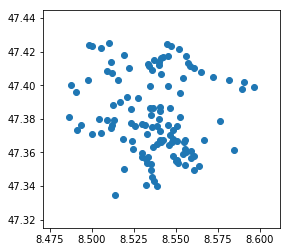

In [171]:
df_parks = explore_shape_file("park.shp")
df_parks.plot()

In [152]:
def join_points_with_zips(df):    
    pointInPoly = gp.gpd.sjoin(df, zips, op='within') 
    display(pointInPoly.head(2))
    print(pointInPoly.shape[0])
    return pointInPoly
    
df_parks = join_points_with_zips(df_parks)

,infrastruk,name,www,geometry,index_right,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF
0,Behinderten-WC;NULL,Hardaupark,None,POINT (8.50940278693184 47.3795806101971),3221,{F9E59568-E19E-47A4-9022-C0C1C587B136},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8004,0
14,Besuchenden-WC;NULL,Kasernenareal,http://www.stadt-zuerich.ch/ted/de/index/gsz/n...,POINT (8.531864674159614 47.37643770121873),3221,{F9E59568-E19E-47A4-9022-C0C1C587B136},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8004,0


118


### Explore street lights in Zurich

Number of entries in Beleuchtung.shp file: 40010
art_txt     object
nisnr       object
geometry    object
dtype: object


,art_txt,nisnr,geometry
0,Beleuchtung,BST118741,(POINT (2683335.222 1254073.184))
1,Beleuchtung,BST118711,(POINT (2682929.935 1253976.845))


coordinate system:  {'init': 'epsg:2056'}
converting to default coordinate system
coordinate system:  {'init': 'epsg:4326'}


,art_txt,nisnr,geometry
0,Beleuchtung,BST118741,(POINT (8.543260623475565 47.43218275032992))
1,Beleuchtung,BST118711,(POINT (8.537871225057431 47.4313675400746))
2,Beleuchtung,BST118712,(POINT (8.537544181282977 47.43138334941374))
3,Beleuchtung,BST118713,(POINT (8.537085392283943 47.43143030868148))
4,Beleuchtung,BST118680,(POINT (8.538170221035513 47.43130304583582))


,art_txt,nisnr,geometry,index_right,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF
0,Beleuchtung,BST118741,(POINT (8.543260623475565 47.43218275032992)),2484,{222310FE-FB64-4C8B-B31D-9431D4F20A08},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8052,0
1,Beleuchtung,BST118711,(POINT (8.537871225057431 47.4313675400746)),2484,{222310FE-FB64-4C8B-B31D-9431D4F20A08},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8052,0


40010


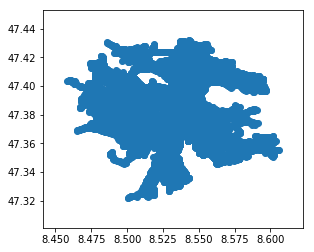

In [118]:
df_stree_lights = explore_shape_file("Beleuchtung.shp")
df_stree_lights = join_points_with_zips(df_stree_lights)
df_stree_lights.plot()

### Public Retirement Home in Zurich

Number of entries in Alterszentrum.shp file: 28
adresse     object
name        object
ort         object
plz         object
tel         object
www         object
geometry    object
dtype: object


,adresse,name,ort,plz,tel,www,geometry
0,Bullingerstrasse 69,Alterszentrum Bullinger-Hardau,Zürich,8004,+41 44 414 15 15,http://www.stadt-zuerich.ch/alterszentren,POINT (2680945 1248353)
1,Leonhardstrasse 18,Alterszentrum Bürgerasyl-Pfrundhaus,Zürich,8001,+41 44 414 11 11,http://www.stadt-zuerich.ch/alterszentren,POINT (2683627.89794577 1247977.83467536)


coordinate system:  {'init': 'epsg:2056'}
converting to default coordinate system
coordinate system:  {'init': 'epsg:4326'}


,adresse,name,ort,plz,tel,www,geometry
0,Bullingerstrasse 69,Alterszentrum Bullinger-Hardau,Zürich,8004,+41 44 414 15 15,http://www.stadt-zuerich.ch/alterszentren,POINT (8.510545775203486 47.38103754510054)
1,Leonhardstrasse 18,Alterszentrum Bürgerasyl-Pfrundhaus,Zürich,8001,+41 44 414 11 11,http://www.stadt-zuerich.ch/alterszentren,POINT (8.545999521081981 47.37732848124672)
2,Ebelstrasse 29,Alterszentrum Doldertal,Zürich,8032,+41 44 414 39 50,http://www.stadt-zuerich.ch/alterszentren,POINT (8.566546390422625 47.37449558381359)
3,Dorflindenstrasse 4,Alterszentrum Dorflinde,Zürich,8050,+41 44 414 22 00,http://www.stadt-zuerich.ch/alterszentren,POINT (8.549511889179938 47.4079591563646)
4,Bändlistrasse 10,Alterszentrum Grünau,Zürich,8064,+41 44 414 13 13,http://www.stadt-zuerich.ch/alterszentren,POINT (8.490018228576437 47.39516720926085)


,adresse,name,ort,plz,tel,www,geometry,index_right,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF
0,Bullingerstrasse 69,Alterszentrum Bullinger-Hardau,Zürich,8004,+41 44 414 15 15,http://www.stadt-zuerich.ch/alterszentren,POINT (8.510545775203486 47.38103754510054),3221,{F9E59568-E19E-47A4-9022-C0C1C587B136},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8004,0
5,Norastrasse 38,Alterszentrum Hardau,Zürich,8004,+41 44 405 46 56,http://www.stadt-zuerich.ch/alterszentren,POINT (8.509112263053128 47.38159821046744),3221,{F9E59568-E19E-47A4-9022-C0C1C587B136},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8004,0


28


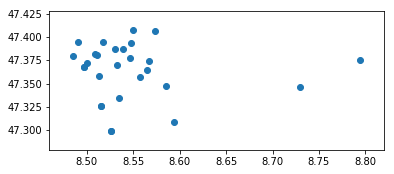

In [119]:
df_retirement_home = explore_shape_file("Alterszentrum.shp")
df_retirement_home = join_points_with_zips(df_retirement_home)
df_retirement_home.plot()

### Alterswohnung in Zurich

Number of entries in Alterswohnung.shp file: 36
adresse     object
name        object
ort         object
plz         object
www         object
geometry    object
dtype: object


,adresse,name,ort,plz,www,geometry
0,Feldblumenstrasse 9,Siedlung Krone Altstetten,Zürich,8048,http://www.wohnenab60.ch/,POINT (2678843.92223771 1249083.86122833)
1,Rebwiesstrasse 26 + 28,Siedlung Rebwies,Zollikon,8702,http://www.wohnenab60.ch/,POINT (2686600.39507685 1244761.89389742)


coordinate system:  {'init': 'epsg:2056'}
converting to default coordinate system
coordinate system:  {'init': 'epsg:4326'}


,adresse,name,ort,plz,www,geometry
0,Feldblumenstrasse 9,Siedlung Krone Altstetten,Zürich,8048,http://www.wohnenab60.ch/,POINT (8.482854189355919 47.3878652703197)
1,Rebwiesstrasse 26 + 28,Siedlung Rebwies,Zollikon,8702,http://www.wohnenab60.ch/,POINT (8.584732952565041 47.34802248963895)
2,Ecke Regensdorferstrasse / Im Stelzenacker,Siedlung Grünwald (ab ca. 2015),Zürich,8049,http://www.wohnenab60.ch/,POINT (8.483014697194005 47.41564040789979)
3,"Wehntalerstr. 440, Neuwiesenstr. 9, Einfangstr...",Siedlung Frieden,Zürich,8046,http://www.wohnenab60.ch/,POINT (8.513739896650042 47.41604164029717)
4,Feldstrasse 110,Siedlung Feldstrasse,Zürich,8036,http://www.wohnenab60.ch/feldstrasse,POINT (8.52365535971918 47.3790171985281)


,adresse,name,ort,plz,www,geometry,index_right,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF
0,Feldblumenstrasse 9,Siedlung Krone Altstetten,Zürich,8048,http://www.wohnenab60.ch/,POINT (8.482854189355919 47.3878652703197),1768,{00814703-7B97-436C-A65E-7E7C37492E12},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8048,0
27,Eulenweg 24,Siedlung Buchlern,Zürich,8048,http://www.wohnenab60.ch/,POINT (8.482095339976311 47.3835557642306),1768,{00814703-7B97-436C-A65E-7E7C37492E12},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8048,0


36


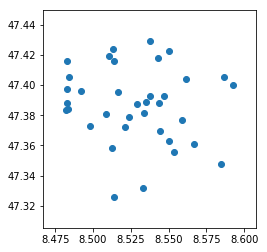

In [121]:
df_retirement_home = explore_shape_file("Alterswohnung.shp")
df_retirement_home = join_points_with_zips(df_retirement_home)
df_retirement_home.plot()

###  Handicapped parking (behindertenparkplatz) in Zurich

Number of entries in behindertenparkplatz.shp file: 410
adresse       object
distanz       object
gebpflicht    object
orientieru    object
geometry      object
dtype: object


,adresse,distanz,gebpflicht,orientieru,geometry
0,Ueberlandstrasse 460,None,0,None,POINT (2687257.96118109 1251041.96933696)
1,Ueberlandstrasse 460,None,0,None,POINT (2687253.29805644 1251044.14192912)


coordinate system:  {'init': 'epsg:2056'}
converting to default coordinate system
coordinate system:  {'init': 'epsg:4326'}


,adresse,distanz,gebpflicht,orientieru,geometry
0,Ueberlandstrasse 460,None,0,None,POINT (8.59465858521016 47.40441422651615)
1,Ueberlandstrasse 460,None,0,None,POINT (8.594597238915972 47.40443438291725)
2,Hardstrasse 210,None,0,None,POINT (8.517385572672554 47.38560685775773)
3,Querstrasse 16,None,0,None,POINT (8.544245215338798 47.40969657194379)
4,Querstrasse 16,None,0,None,POINT (8.544280979384066 47.40970553972641)


,adresse,distanz,gebpflicht,orientieru,geometry,index_right,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF
0,Ueberlandstrasse 460,None,0,None,POINT (8.59465858521016 47.40441422651615),2276,{69FED1DC-7E98-485A-A196-CE3F3DE1D322},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8051,0
1,Ueberlandstrasse 460,None,0,None,POINT (8.594597238915972 47.40443438291725),2276,{69FED1DC-7E98-485A-A196-CE3F3DE1D322},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8051,0


410


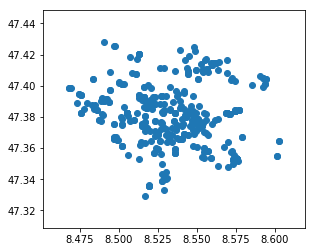

In [122]:
df_handicapped_parking = explore_shape_file("behindertenparkplatz.shp")
df_handicapped_parking = join_points_with_zips(df_handicapped_parking)
df_handicapped_parking.plot()

###  Fontaines (brunnen) in Zurich

Number of entries in brunnen.shp file: 1281
objectid        int64
nummer         object
brunnenart     object
historisch    float64
wasserart_     object
bezeichnun     object
geometry       object
dtype: object


,objectid,nummer,brunnenart,historisch,wasserart_,bezeichnun,geometry
0,1,510,öffentlicher Brunnen,1970.0,Verteilnetz,Aussichtsturm,POINT (2687661.897 1247193.723000001)
1,2,349,öffentlicher Brunnen,1933.0,Verteilnetz,None,POINT (2687024.921999998 1247133.210999999)


coordinate system:  {'init': 'epsg:2056'}
converting to default coordinate system
coordinate system:  {'init': 'epsg:4326'}


,objectid,nummer,brunnenart,historisch,wasserart_,bezeichnun,geometry
0,1,510,öffentlicher Brunnen,1970.0,Verteilnetz,Aussichtsturm,POINT (8.599255291809964 47.36975239415667)
1,2,349,öffentlicher Brunnen,1933.0,Verteilnetz,None,POINT (8.5908112950803 47.36929262016639)
2,3,365,öffentlicher Brunnen,1965.0,Quellwasser,Biberlinterrasse,POINT (8.575753921528584 47.36612993723469)
3,4,338,öffentlicher Brunnen,1910.0,Quellwasser,None,POINT (8.564845390159684 47.37099303933551)
4,5,6069,Notwasserbrunnen,1988.0,Quellwasser,None,POINT (8.564390324733079 47.36932669952166)


,objectid,nummer,brunnenart,historisch,wasserart_,bezeichnun,geometry,index_right,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF
0,1,510,öffentlicher Brunnen,1970.0,Verteilnetz,Aussichtsturm,POINT (8.599255291809964 47.36975239415667),1839,{332F6A09-9DCC-4D84-9108-DA9270F95A10},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8053,0
1,2,349,öffentlicher Brunnen,1933.0,Verteilnetz,None,POINT (8.5908112950803 47.36929262016639),1839,{332F6A09-9DCC-4D84-9108-DA9270F95A10},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8053,0


1281


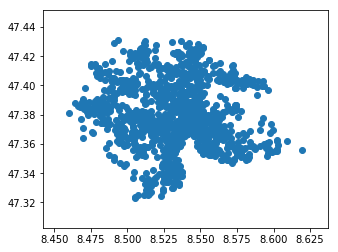

In [124]:
df_fountains = explore_shape_file("brunnen.shp")
df_fountains = join_points_with_zips(df_fountains)
df_fountains.plot()

### Youth clubs/centers/ meeting center (Jugendtreff) in Zurich

Number of entries in Jugendtreff.shp file: 13
adresse     object
name        object
ort         object
plz         object
tel         object
www         object
geometry    object
dtype: object


,adresse,name,ort,plz,tel,www,geometry
0,Glaubtenstrasse 27,OJA Affoltern,Zürich,8046,+41 44 372 10 84,https://www.oja.ch/einrichtungen/oja-affoltern/,POINT (2681372 1251842)
1,Magnusstrasse 5,Verein Jugendtreff Kreis 4,Zürich,8004,+41 44 242 88 55,http://www.jugi4.ch,POINT (2682002 1248209)


coordinate system:  {'init': 'epsg:2056'}
converting to default coordinate system
coordinate system:  {'init': 'epsg:4326'}


,adresse,name,ort,plz,tel,www,geometry
0,Glaubtenstrasse 27,OJA Affoltern,Zürich,8046,+41 44 372 10 84,https://www.oja.ch/einrichtungen/oja-affoltern/,POINT (8.516834437019998 47.4123627310934)
1,Magnusstrasse 5,Verein Jugendtreff Kreis 4,Zürich,8004,+41 44 242 88 55,http://www.jugi4.ch,POINT (8.524515021642355 47.37961179305172)
2,Segnesstrasse 6,OJA Kreis 9 & Hard,Zürich,8048,+41 44 400 03 82,https://www.oja.ch/einrichtungen/oja-kreis-9-h...,POINT (8.485666944175653 47.38873157148882)
3,Albisstrasse 40,OJA Wollishofen-Leimbach,Zürich,8038,+41 43 243 11 49,https://www.oja.ch/einrichtungen/oja-wollishof...,POINT (8.530435344724037 47.34408807334084)
4,Sihlquai 240,OJA Kreis 5/planet 5,Zürich,8005,+41 44 278 10 70,https://www.oja.ch/einrichtungen/oja-kreis-5-p...,POINT (8.530053666377217 47.38752026290876)


,adresse,name,ort,plz,tel,www,geometry,index_right,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF
0,Glaubtenstrasse 27,OJA Affoltern,Zürich,8046,+41 44 372 10 84,https://www.oja.ch/einrichtungen/oja-affoltern/,POINT (8.516834437019998 47.4123627310934),1785,{5AD56811-E24C-49AF-8E6F-21A7E4D328D4},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8046,0
1,Magnusstrasse 5,Verein Jugendtreff Kreis 4,Zürich,8004,+41 44 242 88 55,http://www.jugi4.ch,POINT (8.524515021642355 47.37961179305172),3221,{F9E59568-E19E-47A4-9022-C0C1C587B136},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8004,0


13


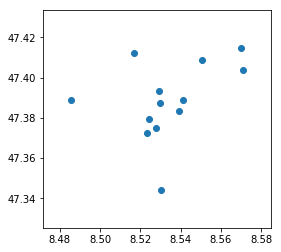

In [125]:
df_youth_centers = explore_shape_file("Jugendtreff.shp")
df_youth_centers = join_points_with_zips(df_youth_centers)
df_youth_centers.plot()

### Kindergarten in Zurich

Number of entries in kindergarten.shp file: 354
adresse     object
name        object
ort         object
plz         object
tel         object
www         object
geometry    object
dtype: object


,adresse,name,ort,plz,tel,www,geometry
0,Leimbachstrasse 21,Sihlbogen,Zürich,8041,044 480 02 16,https://www.stadt-zuerich.ch/schulen/de/fallet...,POINT Z (2681638.019 1243400.62 0)
1,Rebenweg 1,Rebenweg I,Zürich,8041,044 481 83 21,https://www.stadt-zuerich.ch/schulen/de/fallet...,POINT Z (2681271.605 1243147.887 0)


coordinate system:  {'init': 'epsg:2056'}
converting to default coordinate system
coordinate system:  {'init': 'epsg:4326'}


,adresse,name,ort,plz,tel,www,geometry
0,Leimbachstrasse 21,Sihlbogen,Zürich,8041,044 480 02 16,https://www.stadt-zuerich.ch/schulen/de/fallet...,POINT Z (8.518819287385639 47.33641307883338 4...
1,Rebenweg 1,Rebenweg I,Zürich,8041,044 481 83 21,https://www.stadt-zuerich.ch/schulen/de/fallet...,POINT Z (8.513925869312036 47.33418538216387 4...
2,Bruderwies 55,Bruderwies I,Zürich,8041,044 413 11 60,https://www.stadt-zuerich.ch/schulen/de/fallet...,POINT Z (8.517024408982754 47.33353553507356 4...
3,Zwirnerstrasse 269,Zwirnerstrasse,Zürich,8041,043 399 96 79,https://www.stadt-zuerich.ch/schulen/de/fallet...,POINT Z (8.518154720935057 47.33673743846816 4...
4,Bruderwies 55,Bruderwies II,Zürich,8041,044 413 11 61,https://www.stadt-zuerich.ch/schulen/de/fallet...,POINT Z (8.517024408982754 47.33353553507356 4...


,adresse,name,ort,plz,tel,www,geometry,index_right,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF
0,Leimbachstrasse 21,Sihlbogen,Zürich,8041,044 480 02 16,https://www.stadt-zuerich.ch/schulen/de/fallet...,POINT Z (8.518819287385639 47.33641307883338 4...,2280,{D7D386CB-EB1C-4806-85C5-F9E0DDFB73B9},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8041,0
1,Rebenweg 1,Rebenweg I,Zürich,8041,044 481 83 21,https://www.stadt-zuerich.ch/schulen/de/fallet...,POINT Z (8.513925869312036 47.33418538216387 4...,2280,{D7D386CB-EB1C-4806-85C5-F9E0DDFB73B9},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8041,0


354


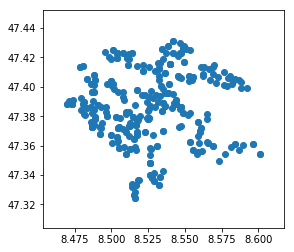

In [127]:
df_kindergarten = explore_shape_file("kindergarten.shp")
df_kindergarten = join_points_with_zips(df_kindergarten)
df_kindergarten.plot()

### kinderhaus_eltern_kind_zentrum in Zurich

Number of entries in kinderhaus.shp file: 16
adresse     object
name        object
ort         object
plz         object
tel         object
www         object
geometry    object
dtype: object


,adresse,name,ort,plz,tel,www,geometry
0,Bullingerstrasse 60,Familientreff Hard,Zürich,8004,+41 44 412 83 89,None,POINT (2680882 1248472)
1,Ecke Stauffacherstrasse/Feldstrasse,Spielinsel Bäckeranlage,Zürich,8004,+41 77 480 26 59,None,POINT (2681882.8999983 1248033.84336279)


coordinate system:  {'init': 'epsg:2056'}
converting to default coordinate system
coordinate system:  {'init': 'epsg:4326'}


,adresse,name,ort,plz,tel,www,geometry
0,Bullingerstrasse 60,Familientreff Hard,Zürich,8004,+41 44 412 83 89,None,POINT (8.509733104402118 47.38211549634609)
1,Ecke Stauffacherstrasse/Feldstrasse,Spielinsel Bäckeranlage,Zürich,8004,+41 77 480 26 59,None,POINT (8.522906025375406 47.37805135396079)
2,Glatttalstrasse 1a,Familienzentrum Katzenbach,Zürich,8052,+41 44 300 12 28,http://www.gfz-zh.ch,POINT (8.550252299543796 47.42243546516777)
3,Frohalpstrasse 76 (freig.),Kinderhaus Entlisberg,Zürich,8038,None,https://www.stadt-zuerich.ch/sd/de/index/famil...,POINT (8.524557815023671 47.34011365772861)
4,Viaduktstrasse 55,Kindertreff Viadukt,Zürich,8005,+41 44 412 83 94,http://www.stadt-zuerich.ch/viadukt,POINT (8.522895455414137 47.38658021016231)


,adresse,name,ort,plz,tel,www,geometry,index_right,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF
0,Bullingerstrasse 60,Familientreff Hard,Zürich,8004,+41 44 412 83 89,None,POINT (8.509733104402118 47.38211549634609),3221,{F9E59568-E19E-47A4-9022-C0C1C587B136},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8004,0
1,Ecke Stauffacherstrasse/Feldstrasse,Spielinsel Bäckeranlage,Zürich,8004,+41 77 480 26 59,None,POINT (8.522906025375406 47.37805135396079),3221,{F9E59568-E19E-47A4-9022-C0C1C587B136},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8004,0


16


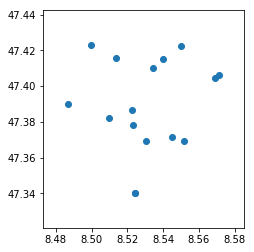

In [129]:
df_kinderhaus_eltern_kind_zentrum = explore_shape_file("kinderhaus.shp")
df_kinderhaus_eltern_kind_zentrum = join_points_with_zips(df_kinderhaus_eltern_kind_zentrum)
df_kinderhaus_eltern_kind_zentrum.plot()

### Churches (kirche) in Zurich

Number of entries in kirche.shp file: 82
adresse     object
name        object
ort         object
plz         object
geometry    object
dtype: object


,adresse,name,ort,plz,geometry
0,Friedheimstrasse 4,Christuskirche (christ. kath),Zürich,None,POINT (2683814.91747696 1251021.84270969)
1,Narzissenstrasse 10,"Russisch-Orthodoxe Kirche Hl. Pokrov, Mariasch...",Zürich,None,POINT (2683649.89857569 1248558.835249)


coordinate system:  {'init': 'epsg:2056'}
converting to default coordinate system
coordinate system:  {'init': 'epsg:4326'}


,adresse,name,ort,plz,geometry
0,Friedheimstrasse 4,Christuskirche (christ. kath),Zürich,None,POINT (8.549045990558032 47.40468042513416)
1,Narzissenstrasse 10,"Russisch-Orthodoxe Kirche Hl. Pokrov, Mariasch...",Zürich,None,POINT (8.546399408180612 47.38255082681778)
2,Brandschenkestrasse 14,Mision Catolica de Lengua Espanola (röm. kath),None,None,POINT (8.53311182210714 47.36946362240806)
3,Saatlenstrasse 240,Kirche Saatlen (evang. ref),Zürich,None,POINT (8.56388342859281 47.4102307594279)
4,Auf der Egg 11,Neue Kirche Wollishofen (evang. ref),Zürich,None,POINT (8.532318684002094 47.34178399115859)


,adresse,name,ort,plz,geometry,index_right,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF
0,Friedheimstrasse 4,Christuskirche (christ. kath),Zürich,None,POINT (8.549045990558032 47.40468042513416),2850,{B54BC1B3-3482-4300-8334-EF9E7DE6BA24},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8057,0
30,Wehntalerstrasse 220,Allerheiligen Kirche (röm. kath),Zürich,None,POINT (8.529352270855291 47.40895177920019),2850,{B54BC1B3-3482-4300-8334-EF9E7DE6BA24},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8057,0


82


,adresse,name,ort,plz,geometry,index_right,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF
0,Friedheimstrasse 4,Christuskirche (christ. kath),Zürich,None,POINT (8.549045990558032 47.40468042513416),2850,{B54BC1B3-3482-4300-8334-EF9E7DE6BA24},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8057,0
30,Wehntalerstrasse 220,Allerheiligen Kirche (röm. kath),Zürich,None,POINT (8.529352270855291 47.40895177920019),2850,{B54BC1B3-3482-4300-8334-EF9E7DE6BA24},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8057,0
42,Oerlikonerstrasse 99,Kirche Oerlikon (evang. ref),Zürich,None,POINT (8.5464116453267 47.40606397417338),2850,{B54BC1B3-3482-4300-8334-EF9E7DE6BA24},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8057,0
45,Hoffeld 4,Kirche Matthäus (evang. ref),Zürich,None,POINT (8.533725087402956 47.40509652555985),2850,{B54BC1B3-3482-4300-8334-EF9E7DE6BA24},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8057,0
80,Milchbuckstrasse 61,Pauluskirche (evang. ref),Zürich,None,POINT (8.543274889911608 47.39409454442398),2850,{B54BC1B3-3482-4300-8334-EF9E7DE6BA24},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8057,0


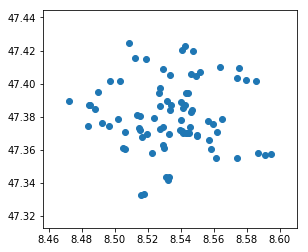

In [137]:
def read_and_join(file_name):
    df = explore_shape_file(file_name)
    df = join_points_with_zips(df)
    df.plot()
    return df

df_churches = read_and_join("kirche.shp")
df_churches.head()

### Roman-Catholic Parish (Kirchgemeinde Roemisch Katholisch)

In [135]:
#df_parish = read_and_join("KirchgemeindeRoemischKatholisch.shp")
#it is a polygon as well so we don't care

### Temporary art in the urban space (Kunst im Stadtraum)

Number of entries in KunstImStadtraum.shp file: 388
poi_id        object
titel         object
datierung     object
gattung       object
material_t    object
kuenstler_    object
standort      object
geometry      object
dtype: object


,poi_id,titel,datierung,gattung,material_t,kuenstler_,standort,geometry
0,kir3009,[Liegende weibliche Figur],1935 (platziert 1937),Freiplastik,"Bronze (Plastik), Stein (Sockel)",Franz Fischer (1900-1980),"Friedhof Enzenbühl, Teichanlage (bei Forchstra...",POINT (2686317.804 1244857.75)
1,kir4368,[Steinvase auf Sockel],1937,Freiplastik,Stein,Luigi Zanini (1896-1968),"Friedhof Enzenbühl, Feld H (bei Forchstrasse 384)",POINT (2686354.881 1244781.803)


coordinate system:  {'init': 'epsg:2056'}
converting to default coordinate system
coordinate system:  {'init': 'epsg:4326'}


,poi_id,titel,datierung,gattung,material_t,kuenstler_,standort,geometry
0,kir3009,[Liegende weibliche Figur],1935 (platziert 1937),Freiplastik,"Bronze (Plastik), Stein (Sockel)",Franz Fischer (1900-1980),"Friedhof Enzenbühl, Teichanlage (bei Forchstra...",POINT (8.58101201618712 47.34892162110899)
1,kir4368,[Steinvase auf Sockel],1937,Freiplastik,Stein,Luigi Zanini (1896-1968),"Friedhof Enzenbühl, Feld H (bei Forchstrasse 384)",POINT (8.581488009992405 47.34823374570527)
2,kir2827,"""Alfred-Escher-Brunnen""",1884-1889,None,"Bronze, Stein",Richard Kissling (1848-1919),Bahnhofplatz (bei Bahnhofplatz 15),POINT (8.539954974922273 47.37712558230368)
3,kir2979,Augustin-Pyrame-de-Candolle-Denkmal,nicht bekannt,Freiplastik,"Bronze (Büste), Stein (Sockel)",Jakob Keller (1859-1911),"Alter Botanischer Garten ""Zur Katz"" (bei Pelik...",POINT (8.534698617554461 47.37050311100636)
4,kir2819,"""Basiliskenbrunnen""",1884 (platziert 1983),Brunnen,"Gusseisen, lackiert",Wilhelm Bubeck (1850-1891),Sihlporte (bei Talstrasse 82),POINT (8.534442797450909 47.37233975555253)


,poi_id,titel,datierung,gattung,material_t,kuenstler_,standort,geometry,index_right,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF
0,kir3009,[Liegende weibliche Figur],1935 (platziert 1937),Freiplastik,"Bronze (Plastik), Stein (Sockel)",Franz Fischer (1900-1980),"Friedhof Enzenbühl, Teichanlage (bei Forchstra...",POINT (8.58101201618712 47.34892162110899),1935,{6CFDA772-9A63-49A4-A13A-73CA1682F614},{D0F7EA40-9219-475D-8592-E2CC9B536435},real,nein,8702,0
1,kir4368,[Steinvase auf Sockel],1937,Freiplastik,Stein,Luigi Zanini (1896-1968),"Friedhof Enzenbühl, Feld H (bei Forchstrasse 384)",POINT (8.581488009992405 47.34823374570527),1935,{6CFDA772-9A63-49A4-A13A-73CA1682F614},{D0F7EA40-9219-475D-8592-E2CC9B536435},real,nein,8702,0


388


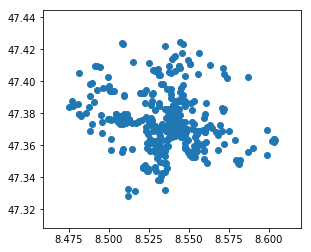

In [136]:
df_art = read_and_join("KunstImStadtraum.shp")

### Picknickplatz

Number of entries in picknickplatz.shp file: 110
infrastruk    object
name          object
kontakt       object
anlageelem    object
geometry      object
dtype: object


,infrastruk,name,kontakt,anlageelem,geometry
0,;1 Abfalleimer_ 1 Feuerplatz_ 4 Sitzbänke_ 1Br...,Oetlisbergweg,"Verschönerungsverein Zürich, 044 821 78 53","Aussicht, Spielplatz, Brunnen",POINT Z (2687949.367 1246036.83 0)
1,;1 Abfalleimer_ 1 Feuerplatz_ 4 Sitzbänke,Bogenweg,"Verschönerungsverein Zürich, 044 821 78 53","Aussicht, Spielwiese",POINT Z (2687970.304 1245946.462 0)


coordinate system:  {'init': 'epsg:2056'}
converting to default coordinate system
coordinate system:  {'init': 'epsg:4326'}


,infrastruk,name,kontakt,anlageelem,geometry
0,;1 Abfalleimer_ 1 Feuerplatz_ 4 Sitzbänke_ 1Br...,Oetlisbergweg,"Verschönerungsverein Zürich, 044 821 78 53","Aussicht, Spielplatz, Brunnen",POINT Z (8.602833554688079 47.3593098126911 47...
1,;1 Abfalleimer_ 1 Feuerplatz_ 4 Sitzbänke,Bogenweg,"Verschönerungsverein Zürich, 044 821 78 53","Aussicht, Spielwiese",POINT Z (8.603092911759132 47.35849431134458 4...
2,;1 Abfalleimer_ 1 Brunnen_ 1 Feuerplatz_ 1 Sit...,Waldhütte Binz,"Verschönerungsverein Zürich, 044 821 78 53",None,POINT Z (8.619103565697721 47.35556571480281 4...
3,;1 Abfalleimer_ 1 Feuerplatz_ 1 Sitzbank,Geerlibuchweg,"Verschönerungsverein Zürich, 044 821 78 53",Aussicht,POINT Z (8.622028482333464 47.35338619510245 4...
4,;1 Brunnen_ 1 Feuerplatz_ 1 Infotafel_ 1 Tisch...,Blockhaus,"GSZ Waldrevier Uetliberg, 044 463 14 04",None,POINT Z (8.475722286394562 47.36792125707975 4...


,infrastruk,name,kontakt,anlageelem,geometry,index_right,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF
0,;1 Abfalleimer_ 1 Feuerplatz_ 4 Sitzbänke_ 1Br...,Oetlisbergweg,"Verschönerungsverein Zürich, 044 821 78 53","Aussicht, Spielplatz, Brunnen",POINT Z (8.602833554688079 47.3593098126911 47...,1839,{332F6A09-9DCC-4D84-9108-DA9270F95A10},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8053,0
1,;1 Abfalleimer_ 1 Feuerplatz_ 4 Sitzbänke,Bogenweg,"Verschönerungsverein Zürich, 044 821 78 53","Aussicht, Spielwiese",POINT Z (8.603092911759132 47.35849431134458 4...,1839,{332F6A09-9DCC-4D84-9108-DA9270F95A10},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8053,0


110


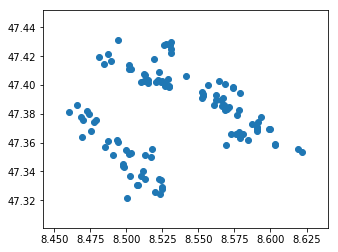

In [138]:
df_picknick = read_and_join("picknickplatz.shp")

### Schulkreis

In [141]:
#df_schulkreis = read_and_join("schulkreis.shp")
#polygon as well, won't be using

### Social Center

Number of entries in sozialzentrum.shp file: 5
adresse     object
name        object
ort         object
plz         object
tel         object
www         object
geometry    object
dtype: object


,adresse,name,ort,plz,tel,www,geometry
0,Albisriederstrasse 330,Sozialzentrum Albisriederhaus,Zürich,8047,+41 44 412 77 77,https://www.stadt-zuerich.ch/sd/de/index/unter...,POINT Z (2679235 1247764 0)
1,Schwamendingenstrasse 41,Sozialzentrum Dorflinde,Zürich,8050,+41 44 412 82 50,https://www.stadt-zuerich.ch/sd/de/index/unter...,POINT Z (2683899 1251303 0)


coordinate system:  {'init': 'epsg:2056'}
converting to default coordinate system
coordinate system:  {'init': 'epsg:4326'}


,adresse,name,ort,plz,tel,www,geometry
0,Albisriederstrasse 330,Sozialzentrum Albisriederhaus,Zürich,8047,+41 44 412 77 77,https://www.stadt-zuerich.ch/sd/de/index/unter...,POINT Z (8.487799414772093 47.37594826890791 4...
1,Schwamendingenstrasse 41,Sozialzentrum Dorflinde,Zürich,8050,+41 44 412 82 50,https://www.stadt-zuerich.ch/sd/de/index/unter...,POINT Z (8.550212570357958 47.40719824076515 4...
2,Selnaustrasse 17,Sozialzentrum Selnau,Zürich,8001,+41 44 412 66 77,https://www.stadt-zuerich.ch/sd/de/index/unter...,POINT Z (8.531720817381895 47.37064765567341 4...
3,Ausstellungsstrasse 88,Sozialzentrum Ausstellungsstrasse,Zürich,8005,+41 44 412 85 00,https://www.stadt-zuerich.ch/sd/de/index/unter...,POINT Z (8.534216749374336 47.38385583643964 4...
4,Hönggerstrasse 24,Sozialzentrum Hönggerstrasse,Zürich,8037,+41 44 412 73 00,https://www.stadt-zuerich.ch/sd/de/index/unter...,POINT Z (8.525896616574958 47.39150829557589 4...


,adresse,name,ort,plz,tel,www,geometry,index_right,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF
0,Albisriederstrasse 330,Sozialzentrum Albisriederhaus,Zürich,8047,+41 44 412 77 77,https://www.stadt-zuerich.ch/sd/de/index/unter...,POINT Z (8.487799414772093 47.37594826890791 4...,2973,{C4A7E591-D4D7-4BB0-8BB0-91FB86ABA1BC},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8047,0
1,Schwamendingenstrasse 41,Sozialzentrum Dorflinde,Zürich,8050,+41 44 412 82 50,https://www.stadt-zuerich.ch/sd/de/index/unter...,POINT Z (8.550212570357958 47.40719824076515 4...,2538,{81BF2DAE-AF54-46FF-91B7-11130B5B3F6D},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8050,0


5


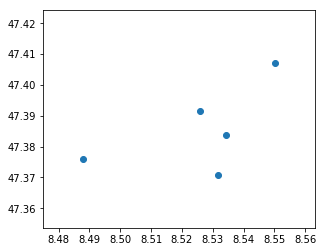

In [143]:
df_social_center = read_and_join("sozialzentrum.shp")

### Gym (Sporthalle)

Number of entries in sporthalle.shp file: 16
adresse     object
name        object
ort         object
plz         object
tel         object
www         object
geometry    object
dtype: object


,adresse,name,ort,plz,tel,www,geometry
0,Döltschiweg 184,Schulsporthalle Döltschi,Zürich,8055,+41 44 413 29 69,https://www.stadt-zuerich.ch/ssd/de/index/spor...,POINT (2680172 1246441)
1,Giesshübelstrasse 41,Sportanlage Saalsporthalle,Zürich,8045,+41 44 413 97 00,https://www.stadt-zuerich.ch/ssd/de/index/spor...,POINT (2681697 1245689)


coordinate system:  {'init': 'epsg:2056'}
converting to default coordinate system
coordinate system:  {'init': 'epsg:4326'}


,adresse,name,ort,plz,tel,www,geometry
0,Döltschiweg 184,Schulsporthalle Döltschi,Zürich,8055,+41 44 413 29 69,https://www.stadt-zuerich.ch/ssd/de/index/spor...,POINT (8.499968091873841 47.36393660345496)
1,Giesshübelstrasse 41,Sportanlage Saalsporthalle,Zürich,8045,+41 44 413 97 00,https://www.stadt-zuerich.ch/ssd/de/index/spor...,POINT (8.520016821941947 47.35698626766018)
2,Rebenstrasse 73,Schulsporthalle Falletsche,Zürich,8041,+41 44 413 11 76,https://www.stadt-zuerich.ch/ssd/de/index/spor...,POINT (8.514595287674856 47.33365843821425)
3,Schönauweg 15,Schulsporthalle Buchwiesen,Zürich,8052,+41 44 413 16 35,https://www.stadt-zuerich.ch/ssd/de/index/spor...,POINT (8.540035663949412 47.42766039426582)
4,Dübendorfstrasse 158,Schulsporthalle Stettbach,Zürich,8051,+41 44 413 25 82,https://www.stadt-zuerich.ch/ssd/de/index/spor...,POINT (8.581922803401037 47.40115902304574)


,adresse,name,ort,plz,tel,www,geometry,index_right,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF
0,Döltschiweg 184,Schulsporthalle Döltschi,Zürich,8055,+41 44 413 29 69,https://www.stadt-zuerich.ch/ssd/de/index/spor...,POINT (8.499968091873841 47.36393660345496),2359,{7ACAC88F-1F6D-4D2C-BE82-4AA30ECE4EFF},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8055,0
1,Giesshübelstrasse 41,Sportanlage Saalsporthalle,Zürich,8045,+41 44 413 97 00,https://www.stadt-zuerich.ch/ssd/de/index/spor...,POINT (8.520016821941947 47.35698626766018),2442,{3D6C74D8-380D-4109-AACE-CD3F38A08CAC},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8045,0


16


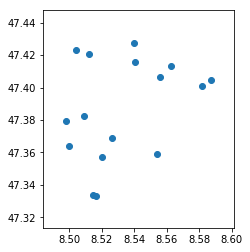

In [144]:
df_gym = read_and_join("sporthalle.shp")

### Stadium

Number of entries in stadion.shp file: 1
adresse     object
name        object
ort         object
plz         object
tel         object
www         object
geometry    object
dtype: object


,adresse,name,ort,plz,tel,www,geometry
0,Badenerstrasse 500,Stadion Letzigrund,Zürich,8048,+41 44 413 94 94,http://www.stadionletzigrund.ch,POINT (2680342 1248553)


coordinate system:  {'init': 'epsg:2056'}
converting to default coordinate system
coordinate system:  {'init': 'epsg:4326'}


,adresse,name,ort,plz,tel,www,geometry
0,Badenerstrasse 500,Stadion Letzigrund,Zürich,8048,+41 44 413 94 94,http://www.stadionletzigrund.ch,POINT (8.502597388272353 47.38291003190781)


,adresse,name,ort,plz,tel,www,geometry,index_right,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF
0,Badenerstrasse 500,Stadion Letzigrund,Zürich,8048,+41 44 413 94 94,http://www.stadionletzigrund.ch,POINT (8.502597388272353 47.38291003190781),1768,{00814703-7B97-436C-A65E-7E7C37492E12},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8048,0


1


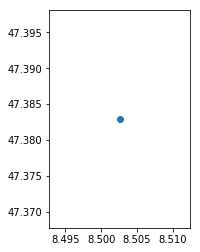

In [145]:
df_stadium = read_and_join("stadion.shp")

### WC not handicapped

Number of entries in ZueriWC_nichtrollstuhlgaengig.shp file: 28
adresse       object
name          object
ort           object
plz           object
tel           object
www           object
typ           object
kommentar     object
gebuehren     object
oeffnungsz    object
standort      object
geometry      object
dtype: object


,adresse,name,ort,plz,tel,www,typ,kommentar,gebuehren,oeffnungsz,standort,geometry
0,Bellerivestrasse 158,Blatterwiese - Fischstube (nicht rollstuhlgängig),Zürich,8008,+41 44 412 43 65,https://www.stadt-zuerich.ch/gud/de/index/gesu...,nicht rollstuhlgängig,"2 Multifunktions-WCs. Das ""provisorische"" WC s...",Gebührenfrei,24h,"Bei der Fischstube im Zürichhorn, Bellerivestr...",POINT Z (2684045 1245299 0)
1,Seestrasse 495b,Hafen Wollishofen (nicht rollstuhlgängig),Zürich,8002,+41 44 412 43 65,https://www.stadt-zuerich.ch/gud/de/index/gesu...,nicht rollstuhlgängig,2 Multifunktions-WCs. Für RollstuhlfahrerInnen...,Gebührenfrei,24h,"Seestr. 495b, bei der Zufahrt zum Rest. Seerose",POINT Z (2683205 1243605 0)


coordinate system:  {'init': 'epsg:2056'}
converting to default coordinate system
coordinate system:  {'init': 'epsg:4326'}


,adresse,name,ort,plz,tel,www,typ,kommentar,gebuehren,oeffnungsz,standort,geometry
0,Bellerivestrasse 158,Blatterwiese - Fischstube (nicht rollstuhlgängig),Zürich,8008,+41 44 412 43 65,https://www.stadt-zuerich.ch/gud/de/index/gesu...,nicht rollstuhlgängig,"2 Multifunktions-WCs. Das ""provisorische"" WC s...",Gebührenfrei,24h,"Bei der Fischstube im Zürichhorn, Bellerivestr...",POINT Z (8.551019101731143 47.3531836409585 47...
1,Seestrasse 495b,Hafen Wollishofen (nicht rollstuhlgängig),Zürich,8002,+41 44 412 43 65,https://www.stadt-zuerich.ch/gud/de/index/gesu...,nicht rollstuhlgängig,2 Multifunktions-WCs. Für RollstuhlfahrerInnen...,Gebührenfrei,24h,"Seestr. 495b, bei der Zufahrt zum Rest. Seerose",POINT Z (8.539588039534847 47.33805530220663 4...
2,Militärstrasse 45,Militärstrasse (Pissoir),Zürich,8004,+41 44 412 43 65,https://www.stadt-zuerich.ch/gud/de/index/gesu...,Pissoir,Pissoir.,Gebührenfrei,24 h,beim Zeughaus.,POINT Z (8.531515461921529 47.37742293127232 4...
3,Langstrasse 30,Obere Langstrasse (Pissoir),Zürich,8004,+41 44 412 43 65,https://www.stadt-zuerich.ch/gud/de/index/gesu...,Pissoir,Pissoir.,Gebührenfrei,24 h,Langstrasse 30 / Beim Kanzleischulhaus,POINT Z (8.525186310595497 47.37551270634128 4...
4,Zeughausstrasse 56,Zeughausstrasse (Pissoir),Zürich,8004,+41 44 412 43 65,https://www.stadt-zuerich.ch/gud/de/index/gesu...,Pissoir,Pissoir.,Gebührenfrei,24 h,Zeughausstr. 56 / Einmündung Rotwandstr.,POINT Z (8.529743296972891 47.37624333281196 4...


,adresse,name,ort,plz,tel,www,typ,kommentar,gebuehren,oeffnungsz,standort,geometry,index_right,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF
0,Bellerivestrasse 158,Blatterwiese - Fischstube (nicht rollstuhlgängig),Zürich,8008,+41 44 412 43 65,https://www.stadt-zuerich.ch/gud/de/index/gesu...,nicht rollstuhlgängig,"2 Multifunktions-WCs. Das ""provisorische"" WC s...",Gebührenfrei,24h,"Bei der Fischstube im Zürichhorn, Bellerivestr...",POINT Z (8.551019101731143 47.3531836409585 47...,2180,{28F933EC-2A5C-46BF-955F-F3006E4DC13B},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8008,0
9,Bellerivestrasse 60,Blatterwiese - Spielplatz (nicht rollstuhlgängig),Zürich,8008,+41 44 412 43 65,https://www.stadt-zuerich.ch/gud/de/index/gesu...,nicht rollstuhlgängig,4 Multifunktions-WCs. Die Anlage befindet sich...,Gebührenfrei,24 h,"Direkt beim Spielplatz an der Blatterwiese, Be...",POINT Z (8.551417798800001 47.35579740652556 4...,2180,{28F933EC-2A5C-46BF-955F-F3006E4DC13B},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8008,0


28


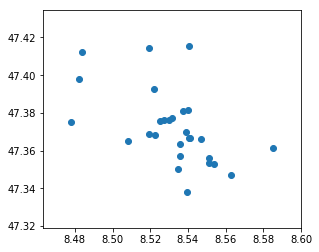

In [147]:
df_stadium = read_and_join("ZueriWC_nichtrollstuhlgaengig.shp")

### WC handicapped

Number of entries in ZueriWC_rollstuhlgaengig.shp file: 77
adresse       object
name          object
ort           object
plz           object
tel           object
www           object
typ           object
standort      object
oeffnungsz    object
gebuehren     object
kommentar     object
geometry      object
dtype: object


,adresse,name,ort,plz,tel,www,typ,standort,oeffnungsz,gebuehren,kommentar,geometry
0,Neumünsterstrasse 16,Neumünster (Rollstuhlgängig mit Eurokey),Zürich,8008,+41 44 412 43 65,https://www.stadt-zuerich.ch/gud/de/index/gesu...,None,Im Neumünsterpark unterhalb der Kirche,Geöffnet 24h. Behinderten,"Behinderten-WC (Fr. 1.-- oder Eurokey), Multif...","Multifunktions- und Behinderten WC, Wickeltisc...",POINT Z (2684619 1246160 0)
1,Uetlibergstrasse 70,Binz (Rollstuhlgängig mit Eurokey),Zürich,8045,+41 44 412 43 65,hhttps://www.stadt-zuerich.ch/gud/de/index/ges...,None,"Uetlibergstrasse 70, Uetlibergbahn-Haltestelle...","MF WC 24h, Behinderten-WC","Behinderten-WC (Fr. 1.-- oder Eurokey), Multif...",Multifunktions- und Behinderten WC. Bei Euroke...,POINT Z (2681587 1246317 0)


coordinate system:  {'init': 'epsg:2056'}
converting to default coordinate system
coordinate system:  {'init': 'epsg:4326'}


,adresse,name,ort,plz,tel,www,typ,standort,oeffnungsz,gebuehren,kommentar,geometry
0,Neumünsterstrasse 16,Neumünster (Rollstuhlgängig mit Eurokey),Zürich,8008,+41 44 412 43 65,https://www.stadt-zuerich.ch/gud/de/index/gesu...,None,Im Neumünsterpark unterhalb der Kirche,Geöffnet 24h. Behinderten,"Behinderten-WC (Fr. 1.-- oder Eurokey), Multif...","Multifunktions- und Behinderten WC, Wickeltisc...",POINT Z (8.558778022256497 47.36085351345452 4...
1,Uetlibergstrasse 70,Binz (Rollstuhlgängig mit Eurokey),Zürich,8045,+41 44 412 43 65,hhttps://www.stadt-zuerich.ch/gud/de/index/ges...,None,"Uetlibergstrasse 70, Uetlibergbahn-Haltestelle...","MF WC 24h, Behinderten-WC","Behinderten-WC (Fr. 1.-- oder Eurokey), Multif...",Multifunktions- und Behinderten WC. Bei Euroke...,POINT Z (8.518675380350361 47.36264777483779 4...
2,Limmatstrasse 313,Escher-Wyss-Platz (rollstuhlgängig mit Eurokey),Zürich,8005,+41 44 412 43 65,https://www.stadt-zuerich.ch/gud/de/index/gesu...,None,Escher-Wyss-Platz bei der Tramhaltestelle stad...,"24 h, Behinderten WC mit",Gebührenfrei. Behinderten-WC mit Eurokey oder ...,Multifunktions- und Behinderten WC.,POINT Z (8.523519190696026 47.38989353867292 4...
3,Püntstrasse 11,Albisrieden Pünt (WC rollstuhlgängig),Zürich,8047,+41 44 412 43 65,https://www.stadt-zuerich.ch/gud/de/index/gesu...,nicht rollstuhlgängig,"Püntstrasse 11, Endstation Tram 3 Albisrieden","Multifunktions-WC 24 h, B","Behinderten-WC Fr. 1.-- oder Eurokey, Multifun...","1 Multifunktions-WC, 1 Behinderten-WC, Wickelt...",POINT Z (8.484670609013309 47.37441150357304 4...
4,Bucheggstrasse 93,Buchegg GZ (rollstuhlgängig mit Eurokey),Zürich,8057,+41 44 412 43 65,https://www.stadt-zuerich.ch/gud/de/index/gesu...,None,"Gemeinschaftszentrum Buchegg, Bucheggplatz","MF-WC 24 h, Behinderten-W","Behinderten-WC Fr. 1.-- oder Eurokey, Damen- u...",Multifunktions- und Behinderten WC. Das GZ wur...,POINT Z (8.535083378697932 47.39894137084008 4...


,adresse,name,ort,plz,tel,www,typ,standort,oeffnungsz,gebuehren,kommentar,geometry,index_right,UUID,OS_UUID,STATUS,INAEND,ZIP,ZUSZIFF
0,Neumünsterstrasse 16,Neumünster (Rollstuhlgängig mit Eurokey),Zürich,8008,+41 44 412 43 65,https://www.stadt-zuerich.ch/gud/de/index/gesu...,None,Im Neumünsterpark unterhalb der Kirche,Geöffnet 24h. Behinderten,"Behinderten-WC (Fr. 1.-- oder Eurokey), Multif...","Multifunktions- und Behinderten WC, Wickeltisc...",POINT Z (8.558778022256497 47.36085351345452 4...,2180,{28F933EC-2A5C-46BF-955F-F3006E4DC13B},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8008,0
13,Seefeldstrasse 103,Höschgasse - Seefeldstrasse (rollstuhlgängig m...,Zürich,8008,+41 44 412 43 65,https://www.stadt-zuerich.ch/gud/de/index/gesu...,None,Seefeldstrasse beim GZ Riesbach,"24 h, Behinderten-WC 06-2",Gebührenfrei. Behinderten-WC Fr. 1.--. oder Eu...,"Multifunktions- und Behinderten WC, Wickeltisch.",POINT Z (8.553845660235657 47.35858948441949 4...,2180,{28F933EC-2A5C-46BF-955F-F3006E4DC13B},{59B3988C-142E-4FA5-804F-7B1232706D43},real,nein,8008,0


77


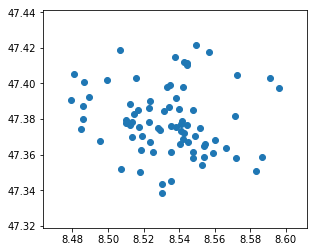

In [149]:
df_stadium = read_and_join("ZueriWC_rollstuhlgaengig.shp")